<a href="https://colab.research.google.com/github/pushpa301/complete-python-course/blob/master/O_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tkinter import messagebox
from tkinter import *
from tkinter import simpledialog
import tkinter
from tkinter import filedialog
import matplotlib.pyplot as plt
import numpy as np
from tkinter.filedialog import askopenfilename
import pandas as pd
import os
from keras.preprocessing import sequence
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

In [12]:

global filename
batch_size = 64
epochs = 10
timesteps = 30
lstm_accuracy=0
arma_accuracy=0

In [13]:

def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print("x "+str(x))
    return (max(train_length_values)) 

In [14]:
def runLSTM():
    global lstm_accuracy
    #current_price = simpledialog.askstring(title="Crude oil Price",prompt="Enter Current Crude Oil Price")
    #text.delete('1.0', END)
    #text.insert(END,"LSTM Predicted Prices loaded\n\n");
    if os.path.exists('models/model.h5'):
        model = tf.keras.models.load_model('models/model.h5')
        print(model.summary())
        strs = 'Date,Value\n'
        price = float(current_price)
        price1 = float(current_price)
        for i in range(0,760):
            if i < 550:
                strs=strs+'1994-10-24,'+str(price)+'\n'
                price = price - 0.005
            if i > 550 and i < 760:
                strs=strs+'1994-10-24,'+str(price1)+'\n'
                price1 = price1 + 0.023
            
        file = open('temp1.txt','w')
        file.write(strs)
        file.close()    
        df_data_1 = pd.read_csv('temp1.txt')
        df_data_1_test = df_data_1[0:734] 
        test_set = df_data_1_test.iloc[:,1:2].values
        sc = MinMaxScaler(feature_range = (0, 1))
        scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))
        X_test = []
        for i in range(timesteps, 734):
            X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        predicted_bcg_values_test_mae = model.predict(X_test, batch_size=batch_size)
        scores = model.evaluate([X_test,X_test], X_test, verbose=2)
        lstm_accuracy = 100 - scores
        model.reset_states()
        predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, (predicted_bcg_values_test_mae.shape[0], predicted_bcg_values_test_mae.shape[1]))
        predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)
        y_test = []
        for j in range(0, 704 - timesteps):
            y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])
        y_test = np.reshape(y_test, (y_test.shape[0], 1))
        index = 0
        cp = float(current_price)
        for i in range(0,len(y_test)):
            if y_test[i-timesteps] < cp:
                index = index + 1
                print(str(y_test[i-timesteps]))
                if index > 5:
                    break;
        index = 0        
        for i in range(0,len(y_test)):
            if y_test[i-timesteps] > cp:
                index = index + 1
                print(str(y_test[i-timesteps]))
                if index > 5:
                    break;
        print(lstm_accuracy)
    else:
        df_data_1 = pd.read_csv('FRED-DCOILWTICO.csv')
        length = len(df_data_1)
        length *= 1 - 0.1
        length = get_train_length(df_data_1, batch_size, 0.1)
        upper_train = length + timesteps*2
        df_data_1_train = df_data_1[0:upper_train]
        training_set = df_data_1_train.iloc[:,1:2].values
        sc = MinMaxScaler(feature_range = (0, 1))
        training_set_scaled = sc.fit_transform(np.float64(training_set))
        X_train = []
        y_train = []
        for i in range(timesteps, length + timesteps): 
            X_train.append(training_set_scaled[i-timesteps:i,0])
            y_train.append(training_set_scaled[i:i+timesteps,0])

        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
        inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
        lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
        lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)
        output_1_mae = Dense(units = 1)(lstm_2_mae)
        regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)
        regressor_mae.compile(optimizer='adam', loss = 'mae')
        regressor_mae.summary()
        parameters = 4 * 10 * (1 + 10 + 1)
        parameters = 4 * 10 * (10 + 10 + 1)
        for i in range(epochs):
            print("Epoch: " + str(i))
            regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
            regressor_mae.reset_states()
        regressor_mae.save(filepath="models/mymodel.h5")

    print(" LSTM Accuracyis\n")
    print(str(lstm_accuracy))
    


In [15]:
def runARMA():
    global arma_accuracy
    current_price = 100
    #text.delete('1.0', END)
    #text.insert(END,"ARMA Predicted Prices loaded\n\n");
    series = pd.read_csv('FRED-DCOILWTICO.csv')
    strs = 'Date,Value\n'
    price = float(current_price)
    for i in range(0,10):
        strs=strs+'1994-10-24,'+str(price)+'\n'
        price = price + 0.005
    file = open('temp1.txt','w')
    file.write(strs)
    file.close()    
    series1 = pd.read_csv("temp1.txt")
    X = np.array(series["Value"])
    X = np.reshape(X,(-1,1))
    Y = np.array(series["Value"])
    tt = np.array(series1["Value"])
    tt = np.reshape(tt,(-1,1))
    train, test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    predictions = []
    history = [x for x in train]
    correct = 0;
    for i in range(len(tt)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = tt[i]
        history.append(obs)
        predict = abs(yhat - obs)
        print('predicted=%f, expected=%f' % (yhat, float(current_price)))
        #text.insert(END,"Current Price : "+current_price+" Predicted Price : "+str(yhat)+"\n")
        if predict < 10:
            correct = correct + 1
            
    arma_accuracy = (correct/len(tt))*100
    print(" ARMA Accuracyis\n")
    print(str(arma_accuracy))


In [9]:
def graph():
    global lstm_accuracy
    global arma_accuracy
    height = [lstm_accuracy,arma_accuracy]
    bars = ('LSTM Model Accuracy','ARMA Model Accuracy')
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, height)
    plt.xticks(y_pos, bars)
    plt.show()


In [7]:
main = tkinter.Tk()
main.title("Crude Oil Price Forecasting") #designing main screen
main.geometry("1300x1200")
def exit():
    global main
    main.destroy()
    
font = ('times', 16, 'bold')
title = Label(main, text='Forecasting Crude Oil Prices: a Deep Learning based Model')
title.config(bg='greenyellow', fg='dodger blue')  
title.config(font=font)           
title.config(height=3, width=120)       
title.place(x=0,y=5)

font1 = ('times', 12, 'bold')
text=Text(main,height=20,width=150)
scroll=Scrollbar(text)
text.configure(yscrollcommand=scroll.set)
text.place(x=50,y=120)
text.config(font=font1)


font1 = ('times', 14, 'bold')
uploadButton = Button(main, text="Upload Crude Oil Dataset", command=upload)
uploadButton.place(x=50,y=550)
uploadButton.config(font=font1)  

lstmButton = Button(main, text="Run Deep Learning LSTM Model & Forecast Price", command=runLSTM)
lstmButton.place(x=330,y=550)
lstmButton.config(font=font1) 

armaButton = Button(main, text="Run Deep Learning ARMA Model & Forecast Price", command=runARMA)
armaButton.place(x=800,y=550)
armaButton.config(font=font1) 

graphButton = Button(main, text="Accuracy Graph", command=graph)
graphButton.place(x=50,y=600)
graphButton.config(font=font1) 

exitButton = Button(main, text="Exit", command=exit)
exitButton.place(x=330,y=600)
exitButton.config(font=font1) 

main.config(bg='LightSkyBlue')
main.mainloop()

TclError: ignored

In [16]:
runLSTM()


x 7616
x 7680
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(64, 30, 1)]             0         
                                                                 
 lstm_2 (LSTM)               (64, 30, 10)              480       
                                                                 
 lstm_3 (LSTM)               (64, 30, 10)              840       
                                                                 
 dense_1 (Dense)             (64, 30, 1)               11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
Epoch: 0
120/120 [==============================] - 5s 18ms/step - loss: 0.0962
Epoch: 1
120/120 [==============================] - 3s 24ms/step - loss: 0.0683
Epoch: 2
120/12

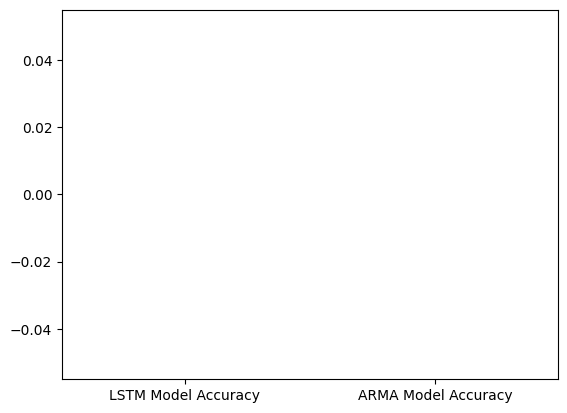

In [11]:
graph()